In [1]:
import json

file_path = 'output3.json'

# Read JSON from the file
with open(file_path, 'r') as file:
    json_data = json.load(file)

In [2]:
!pip install -U sentence-transformers

  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.7.0
    Uninstalling sentence-transformers-2.7.0:
      Successfully uninstalled sentence-transformers-2.7.0


You should consider upgrading via the 'c:\users\maria\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [3]:
import sentence_transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(json_data)
print(embeddings)

c:\users\maria\appdata\local\programs\python\python38\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\users\maria\appdata\local\programs\python\python38\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\maria\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to 

[[-0.03416241 -0.01653879 -0.00283237 ...  0.08591884 -0.09706682
  -0.01656443]
 [-0.02428134 -0.02369632  0.09002735 ... -0.01474708 -0.07846674
  -0.02590319]
 [-0.00364353 -0.04428839 -0.03044017 ... -0.05513426  0.09753487
  -0.02723494]
 ...
 [ 0.00051894 -0.06453953  0.00056793 ... -0.02563462  0.00914404
   0.0397924 ]
 [-0.00481263 -0.01957128  0.03431497 ... -0.03375095 -0.03220239
   0.12384805]
 [ 0.02632469 -0.08531649  0.03302986 ...  0.03541334 -0.05921086
   0.0804214 ]]


In [4]:
!pip install faiss-cpu

You should consider upgrading via the 'c:\users\maria\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [5]:
import faiss
import matplotlib.pyplot as plt

In [6]:
# Brute force search
from scipy.spatial import distance
import numpy as np
def find_k_nearest_neighbors(query_point, data, k):
    distances = [distance.euclidean(query_point, point) for point in data]
    nearest_indices = np.argsort(distances)[:k]
    return nearest_indices


query_point = embeddings[0]


actual100NeighboursInds = find_k_nearest_neighbors(query_point, embeddings, 100)
actual1000NeighboursInds =find_k_nearest_neighbors(query_point, embeddings, 1000)

actualNeighboursIndices = [actual100NeighboursInds, actual1000NeighboursInds]


In [7]:
import timeit
k_variants = [100, 1000]
for k in k_variants:
  execution_times = timeit.repeat(lambda: find_k_nearest_neighbors(query_point, embeddings, k), repeat=10, number=1)
  average_time = sum(execution_times) / len(execution_times)
  print("Среднее время полного перебора = ", average_time, "для k = ", k)


Среднее время полного перебора =  0.3940527799999927 для k =  100
Среднее время полного перебора =  0.40817493000001265 для k =  1000


# FlatL2

In [8]:
import faiss
index = faiss.IndexFlatL2(len(query_point))   # build the index
print(index.is_trained)
index.add(embeddings)                  # add vectors to the index

True


In [9]:
def compareResultWithBruteForce(result_I, bruteForce_I, k):
  intersection = np.intersect1d(result_I, bruteForce_I)
  print("Found ", len(intersection), " out of ", k, " neighbours, which is ", len(intersection) / k, " precision")

In [10]:
def compareResultWithBruteForceRaw(result_I, bruteForce_I, k):
  intersection = np.intersect1d(result_I, bruteForce_I)
  return len(intersection) / k

# HNSWFlat

- M is the number of neighbors used in the graph. A larger M is more accurate but uses more memory

- efConstruction is the depth of exploration at add time

- efSearch is the depth of exploration of the search

In [11]:
def initHNSWIndex(M=64, efConstruction=80, efSearch=64):
    index = faiss.IndexHNSWFlat(384, M)
    index.hnsw.efConstruction = efConstruction
    index.hnsw.efSearch = efSearch
    index.add(embeddings)
    return index


In [12]:
index = initHNSWIndex(32, 40, 32)
D, I = index.search(np.array([query_point]), 100)
compareResultWithBruteForce(I, actual100NeighboursInds, 100)

Found  87  out of  100  neighbours, which is  0.87  precision


In [13]:
ef_searches = [16, 64, 256]
ef_constructions = [40, 80]
m_s = [16, 64, 256]

In [14]:
import math
for k in k_variants:
    for ef_search in ef_searches:
        for ef_construction in ef_constructions:
            for M in m_s:
                index = initHNSWIndex(M, ef_construction, ef_search)
                execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
                average_time = sum(execution_times) / len(execution_times)
                print("Среднее время поиска по HNSW  = ", average_time, "для k = ", k, "ef_search = ", ef_search, "ef_construction = ", ef_construction, "M = ", M)
                D, I =  index.search(np.array([query_point]), k)
                compareResultWithBruteForce(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k)

Среднее время поиска по HNSW  =  0.00025533333333290403 для k =  100 ef_search =  16 ef_construction =  40 M =  16
Found  56  out of  100  neighbours, which is  0.56  precision
Среднее время поиска по HNSW  =  0.0003009999999600647 для k =  100 ef_search =  16 ef_construction =  40 M =  64
Found  86  out of  100  neighbours, which is  0.86  precision
Среднее время поиска по HNSW  =  0.00033669999997224903 для k =  100 ef_search =  16 ef_construction =  40 M =  256
Found  81  out of  100  neighbours, which is  0.81  precision
Среднее время поиска по HNSW  =  0.00017916666665011385 для k =  100 ef_search =  16 ef_construction =  80 M =  16
Found  60  out of  100  neighbours, which is  0.6  precision
Среднее время поиска по HNSW  =  0.0004418666666576125 для k =  100 ef_search =  16 ef_construction =  80 M =  64
Found  91  out of  100  neighbours, which is  0.91  precision
Среднее время поиска по HNSW  =  0.0003738333333179374 для k =  100 ef_search =  16 ef_construction =  80 M =  256
Fo

- centroids: количество ячеек
- nprobe - количество обходимых "соседей" вокруг целевой ячейки

In [15]:
def initIvfFlatIndex(nProbe = 64, n_centroids = 512):
    quantizer = faiss.IndexFlatL2(384);
    index = faiss.IndexIVFFlat(quantizer, 384, n_centroids)
    index.nprobe = nProbe
    index.train(embeddings)
    index.add(embeddings)
    
    return index


In [16]:
index = initIvfFlatIndex(16, 32)
D, I = index.search(np.array([query_point]), 100)
compareResultWithBruteForce(I, actual100NeighboursInds, 100)

Found  83  out of  100  neighbours, which is  0.83  precision


In [17]:
n_probes = [1, 4, 16, 64, 256]
centroids_nums = [16, 32, 125, 512, 1024]

In [18]:

for k in k_variants:
    for nprobe in n_probes:
        for centroids in centroids_nums:
            index = initIvfFlatIndex(nprobe, centroids)
            execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
            average_time = sum(execution_times) / len(execution_times)
            print("Среднее время поиска по IVF  = ", average_time, "для k = ", k, "nprobe = ", nprobe, "centroids = ", centroids)
            D, I =  index.search(np.array([query_point]), k)
            compareResultWithBruteForce(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k)

Среднее время поиска по IVF  =  0.00021403333335001662 для k =  100 nprobe =  1 centroids =  16
Found  33  out of  100  neighbours, which is  0.33  precision
Среднее время поиска по IVF  =  0.0001451000000164034 для k =  100 nprobe =  1 centroids =  32
Found  24  out of  100  neighbours, which is  0.24  precision
Среднее время поиска по IVF  =  7.856666669188901e-05 для k =  100 nprobe =  1 centroids =  125
Found  22  out of  100  neighbours, which is  0.22  precision
Среднее время поиска по IVF  =  8.176666669138892e-05 для k =  100 nprobe =  1 centroids =  512
Found  16  out of  100  neighbours, which is  0.16  precision
Среднее время поиска по IVF  =  0.00011786666671772157 для k =  100 nprobe =  1 centroids =  1024
Found  14  out of  100  neighbours, which is  0.14  precision
Среднее время поиска по IVF  =  0.000852400000023105 для k =  100 nprobe =  4 centroids =  16
Found  69  out of  100  neighbours, which is  0.69  precision
Среднее время поиска по IVF  =  0.0005014333333216806

In [19]:
def initLSHIndex(nbits):
    index = faiss.IndexLSH(384, nbits)
    index.train(embeddings)
    index.add(embeddings)
    
    return index

In [20]:
index = initLSHIndex(16)
D, I = index.search(np.array([query_point]), 100)
compareResultWithBruteForce(I, actual100NeighboursInds, 100)

Found  2  out of  100  neighbours, which is  0.02  precision


In [21]:
nbits_variants = [16, 256, 1024, 4096, 8192]

In [22]:

for k in k_variants:
    for nbits in nbits_variants:
        index = initLSHIndex(nbits)
        execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
        average_time = sum(execution_times) / len(execution_times)
        print("Среднее время поиска по LSH  = ", average_time, "для k = ", k, "nbits = ", nbits)
        D, I =  index.search(np.array([query_point]), k)
        compareResultWithBruteForce(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k)

Среднее время поиска по LSH  =  0.00030583333333803847 для k =  100 nbits =  16
Found  2  out of  100  neighbours, which is  0.02  precision
Среднее время поиска по LSH  =  0.0005877999999862974 для k =  100 nbits =  256
Found  34  out of  100  neighbours, which is  0.34  precision
Среднее время поиска по LSH  =  0.021386066666612653 для k =  100 nbits =  1024
Found  73  out of  100  neighbours, which is  0.73  precision
Среднее время поиска по LSH  =  0.009218133333320111 для k =  100 nbits =  4096
Found  93  out of  100  neighbours, which is  0.93  precision
Среднее время поиска по LSH  =  0.013613033333285784 для k =  100 nbits =  8192
Found  92  out of  100  neighbours, which is  0.92  precision
Среднее время поиска по LSH  =  0.0009534333333552544 для k =  1000 nbits =  16
Found  94  out of  1000  neighbours, which is  0.094  precision
Среднее время поиска по LSH  =  0.0008645000000342407 для k =  1000 nbits =  256
Found  402  out of  1000  neighbours, which is  0.402  precision
С

In [25]:
def initIVFPQIndex(m=384, nlists=42, nprobe=256):
    quantizer = faiss.IndexFlatL2(384)
    index = faiss.IndexIVFPQ(quantizer, 384, nlists, m, 8)
    index.nprobe = nprobe
    index.train(embeddings)
    index.add(embeddings)
    
    return index

In [26]:
index = initIVFPQIndex(96, 42, 256)
D, I = index.search(np.array([query_point]), 100)
compareResultWithBruteForce(I, actual100NeighboursInds, 100)

Found  83  out of  100  neighbours, which is  0.83  precision


In [28]:
nprobes = [256, 512, 1024]
m_s = [96, 192, 384]
nlists_s = [20, 40, 80]

In [29]:
for k in k_variants:
    for nprobe in nprobes:
        for m in m_s:
            for nlists in nlists_s:
                index = initIVFPQIndex(m, nlists, nprobe)
                execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
                average_time = sum(execution_times) / len(execution_times)
                print("Среднее время поиска по IVFPQ  = ", average_time, "для k = ", k, "nprobe = ", nprobe, "nlists = ", nlists, "m = ", m)
                D, I =  index.search(np.array([query_point]), k)
                compareResultWithBruteForce(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k)

Среднее время поиска по IVFPQ  =  0.005218866666685547 для k =  100 nprobe =  256 nlists =  20 m =  96
Found  81  out of  100  neighbours, which is  0.81  precision
Среднее время поиска по IVFPQ  =  0.004898566666649155 для k =  100 nprobe =  256 nlists =  40 m =  96
Found  83  out of  100  neighbours, which is  0.83  precision
Среднее время поиска по IVFPQ  =  0.003965699999980643 для k =  100 nprobe =  256 nlists =  80 m =  96
Found  82  out of  100  neighbours, which is  0.82  precision
Среднее время поиска по IVFPQ  =  0.010917566666724573 для k =  100 nprobe =  256 nlists =  20 m =  192
Found  97  out of  100  neighbours, which is  0.97  precision
Среднее время поиска по IVFPQ  =  0.011016699999951621 для k =  100 nprobe =  256 nlists =  40 m =  192
Found  97  out of  100  neighbours, which is  0.97  precision
Среднее время поиска по IVFPQ  =  0.00970463333336132 для k =  100 nprobe =  256 nlists =  80 m =  192
Found  96  out of  100  neighbours, which is  0.96  precision
Среднее 

# Results

# HNSW Params

In [30]:
ef_searches = [4, 16, 64, 128, 256]
ef_constructions = [20, 40, 80]
m_s = [4, 16, 64, 128, 256]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


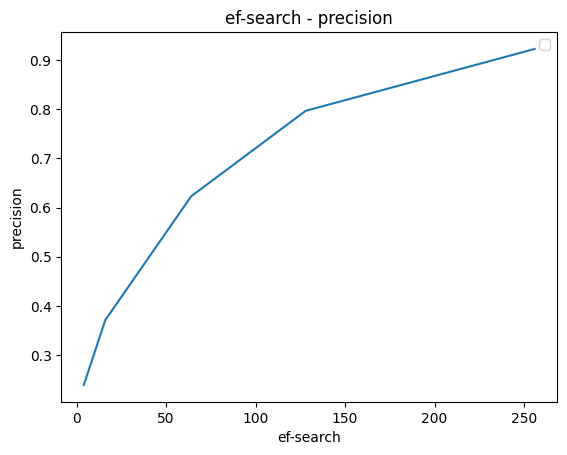

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


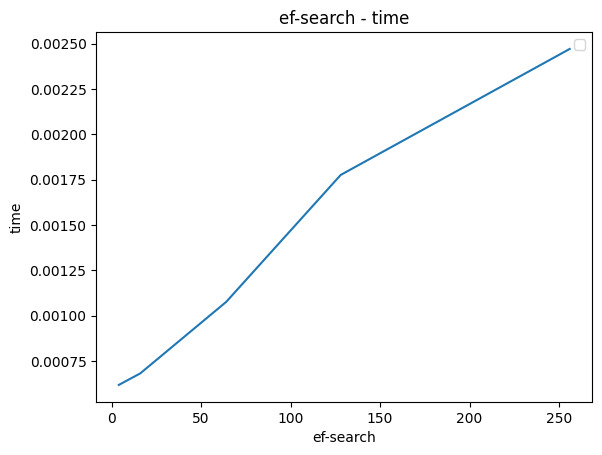

In [31]:
import math
times = []
precisions = []
for ef_search in ef_searches:
    index = initHNSWIndex(efSearch=ef_search)
    execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
    times.append(sum(execution_times) / len(execution_times))
    D, I =  index.search(np.array([query_point]), k)
    precisions.append(compareResultWithBruteForceRaw(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k))
plt.plot(ef_searches, precisions)

plt.xlabel('ef-search')
plt.ylabel('precision')
plt.title('ef-search - precision')

# Add a legend
plt.legend()

# Display the plot
plt.show()

plt.plot(ef_searches, times)

plt.xlabel('ef-search')
plt.ylabel('time')
plt.title('ef-search - time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


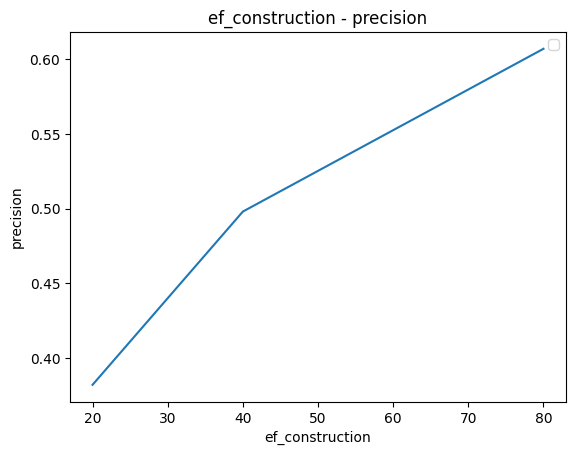

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


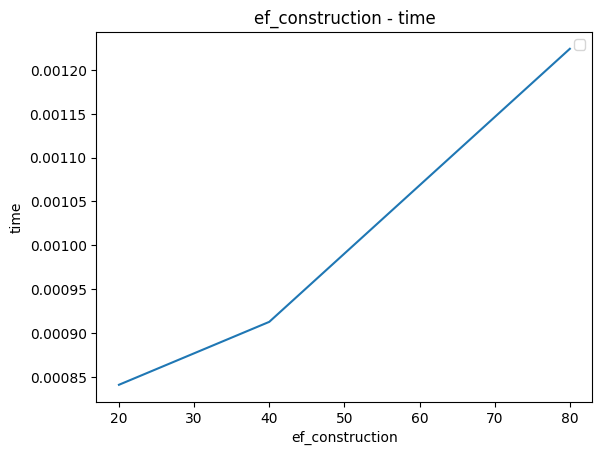

In [32]:
import math
times = []
precisions = []
for ef_construction in ef_constructions:
    index = initHNSWIndex(efConstruction=ef_construction)
    execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
    times.append(sum(execution_times) / len(execution_times))
    D, I =  index.search(np.array([query_point]), k)
    precisions.append(compareResultWithBruteForceRaw(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k))
plt.plot(ef_constructions, precisions)

plt.xlabel('ef_construction')
plt.ylabel('precision')
plt.title('ef_construction - precision')

# Add a legend
plt.legend()

# Display the plot
plt.show()

plt.plot(ef_constructions, times)

plt.xlabel('ef_construction')
plt.ylabel('time')
plt.title('ef_construction - time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


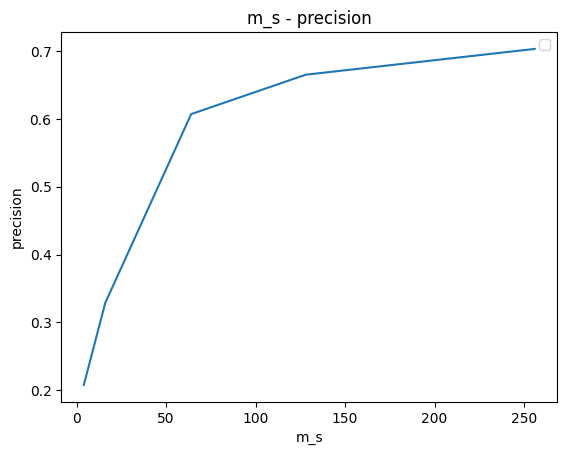

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


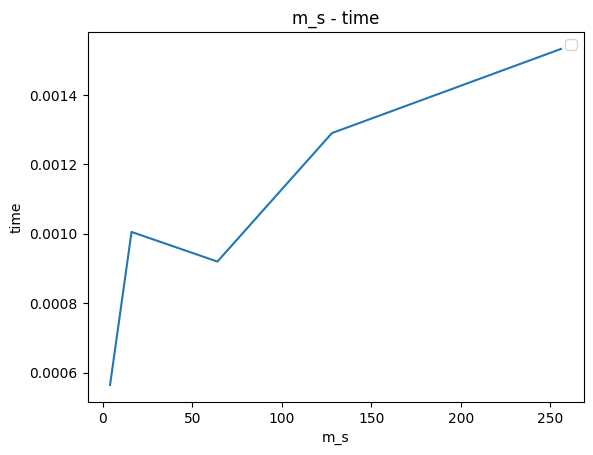

In [33]:
import math
times = []
precisions = []
for m in m_s:
    index = initHNSWIndex(M=m)
    execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
    times.append(sum(execution_times) / len(execution_times))
    D, I =  index.search(np.array([query_point]), k)
    precisions.append(compareResultWithBruteForceRaw(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k))
plt.plot(m_s, precisions)

plt.xlabel('m_s')
plt.ylabel('precision')
plt.title('m_s - precision')

# Add a legend
plt.legend()

# Display the plot
plt.show()

plt.plot(m_s, times)

plt.xlabel('m_s')
plt.ylabel('time')
plt.title('m_s - time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

# IVF Params

In [34]:
n_probes = [1, 4, 16, 64, 256]
centroids_nums = [16, 32, 125, 512, 1024]

In [36]:
quantizer = faiss.IndexFlatL2(384);
for k in k_variants:
    for nprobe in n_probes:
        for centroids in centroids_nums:
            index = initIvfFlatIndex(nprobe, centroids)
            execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
            average_time = sum(execution_times) / len(execution_times)
            print("Среднее время поиска по IVF  = ", average_time, "для k = ", k, "nprobe = ", nprobe, "centroids = ", centroids)
            D, I =  index.search(np.array([query_point]), k)
            compareResultWithBruteForce(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k)

Среднее время поиска по IVF  =  0.00016390000011294129 для k =  100 nprobe =  1 centroids =  16
Found  33  out of  100  neighbours, which is  0.33  precision
Среднее время поиска по IVF  =  0.00012129999997038492 для k =  100 nprobe =  1 centroids =  32
Found  24  out of  100  neighbours, which is  0.24  precision
Среднее время поиска по IVF  =  9.69333332250244e-05 для k =  100 nprobe =  1 centroids =  125
Found  22  out of  100  neighbours, which is  0.22  precision
Среднее время поиска по IVF  =  8.726666662065934e-05 для k =  100 nprobe =  1 centroids =  512
Found  16  out of  100  neighbours, which is  0.16  precision
Среднее время поиска по IVF  =  0.00013336666673543127 для k =  100 nprobe =  1 centroids =  1024
Found  14  out of  100  neighbours, which is  0.14  precision
Среднее время поиска по IVF  =  0.0007743666666707819 для k =  100 nprobe =  4 centroids =  16
Found  69  out of  100  neighbours, which is  0.69  precision
Среднее время поиска по IVF  =  0.000444566666753113

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


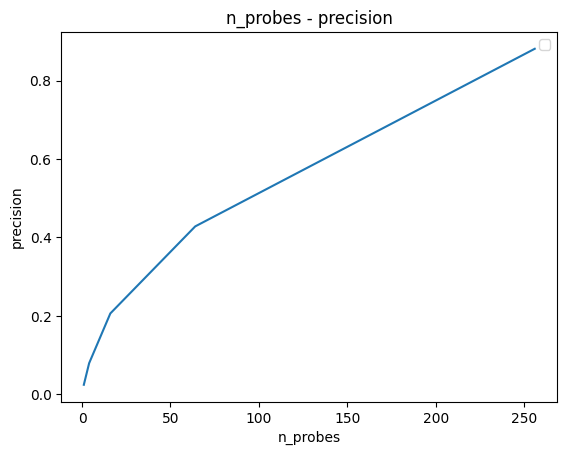

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


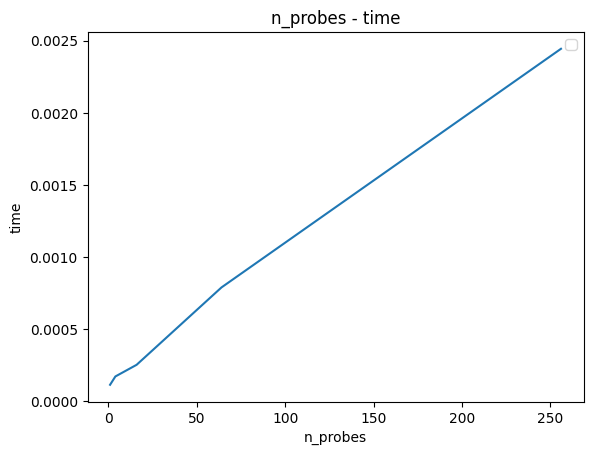

In [37]:
import math
times = []
precisions = []
for nprobe in n_probes:
    index = initIvfFlatIndex(nProbe=nprobe)
    execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
    times.append(sum(execution_times) / len(execution_times))
    D, I =  index.search(np.array([query_point]), k)
    precisions.append(compareResultWithBruteForceRaw(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k))
plt.plot(n_probes, precisions)

plt.xlabel('n_probes')
plt.ylabel('precision')
plt.title('n_probes - precision')

# Add a legend
plt.legend()

# Display the plot
plt.show()

plt.plot(n_probes, times)

plt.xlabel('n_probes')
plt.ylabel('time')
plt.title('n_probes - time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


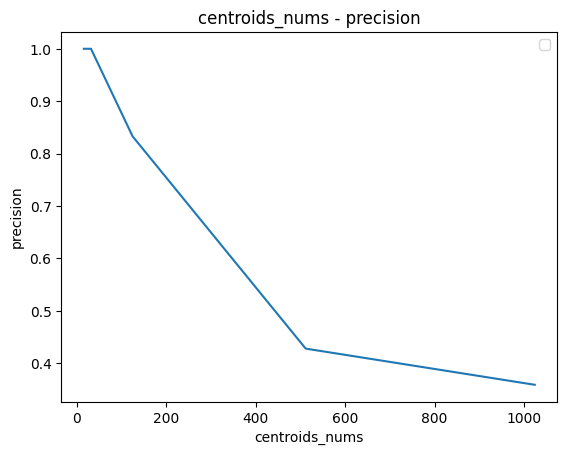

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


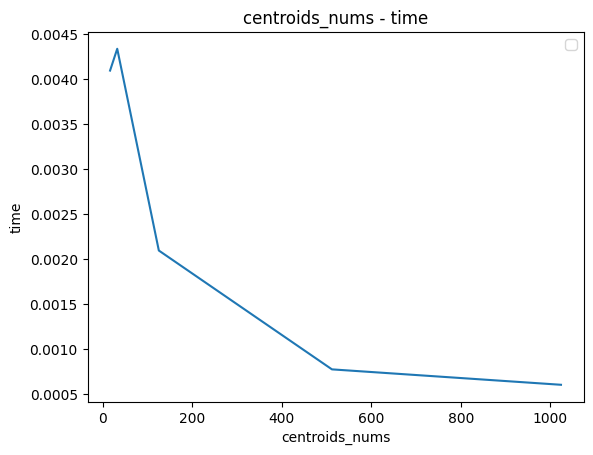

In [38]:
import math
times = []
precisions = []
for n_centroids in centroids_nums:
    index = initIvfFlatIndex(n_centroids=n_centroids)
    execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
    times.append(sum(execution_times) / len(execution_times))
    D, I =  index.search(np.array([query_point]), k)
    precisions.append(compareResultWithBruteForceRaw(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k))
plt.plot(centroids_nums, precisions)

plt.xlabel('centroids_nums')
plt.ylabel('precision')
plt.title('centroids_nums - precision')

# Add a legend
plt.legend()

# Display the plot
plt.show()

plt.plot(centroids_nums, times)

plt.xlabel('centroids_nums')
plt.ylabel('time')
plt.title('centroids_nums - time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

# LSH Params

In [39]:
nbits_variants = [16, 256, 1024, 4096, 8192]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


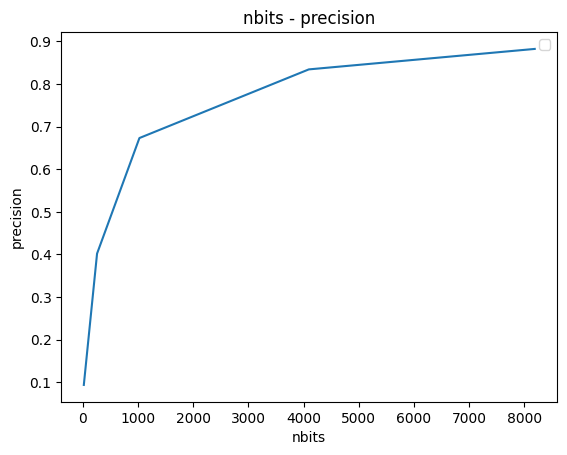

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


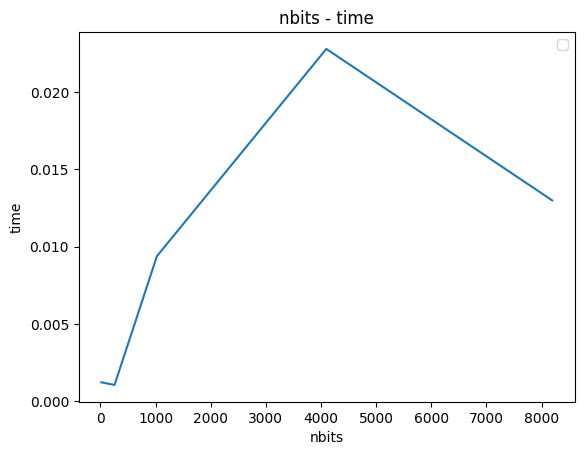

In [40]:
import math
times = []
precisions = []
for nbits in nbits_variants:
    index = initLSHIndex(nbits)
    execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
    times.append(sum(execution_times) / len(execution_times))
    D, I =  index.search(np.array([query_point]), k)
    precisions.append(compareResultWithBruteForceRaw(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k))
plt.plot(nbits_variants, precisions)

plt.xlabel('nbits')
plt.ylabel('precision')
plt.title('nbits - precision')

# Add a legend
plt.legend()

# Display the plot
plt.show()

plt.plot(nbits_variants, times)

plt.xlabel('nbits')
plt.ylabel('time')
plt.title('nbits - time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

# IVFPQ Params

In [44]:
nprobes = [256, 512, 1024]
m_s = [96, 192, 384]
nlists_s = [16, 48, 128, 512]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


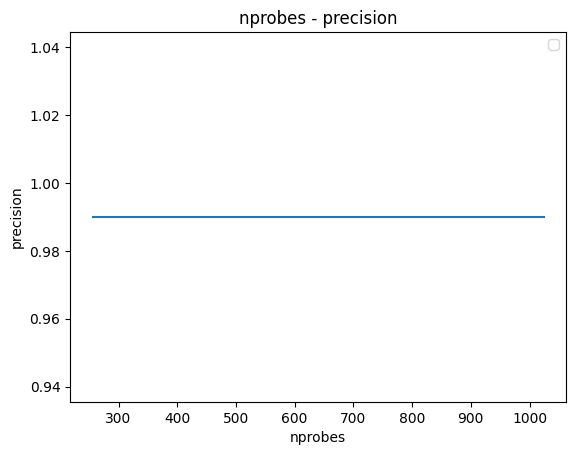

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


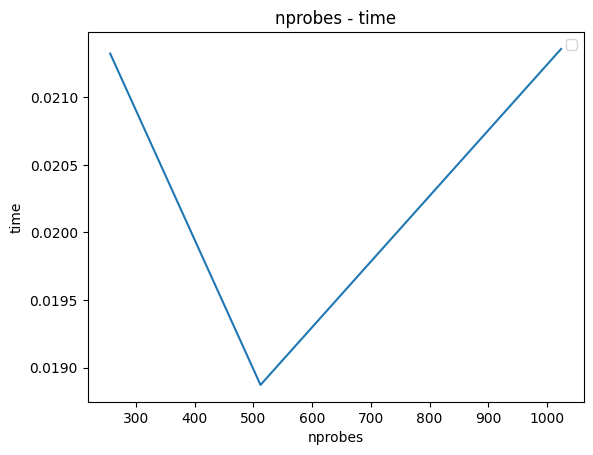

In [45]:
import math
times = []
precisions = []
for nprobe in nprobes:
    index = initIVFPQIndex(nprobe=nprobe)
    execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
    times.append(sum(execution_times) / len(execution_times))
    D, I =  index.search(np.array([query_point]), k)
    precisions.append(compareResultWithBruteForceRaw(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k))
plt.plot(nprobes, precisions)

plt.xlabel('nprobes')
plt.ylabel('precision')
plt.title('nprobes - precision')

# Add a legend
plt.legend()

# Display the plot
plt.show()

plt.plot(nprobes, times)

plt.xlabel('nprobes')
plt.ylabel('time')
plt.title('nprobes - time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


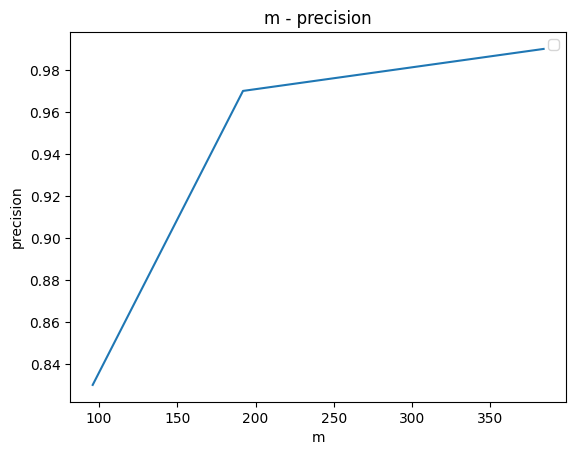

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


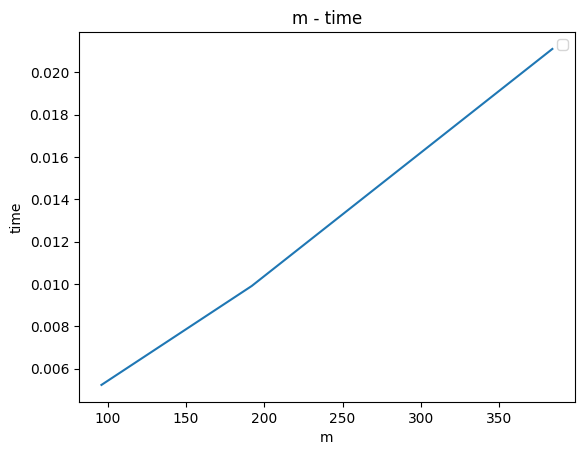

In [46]:
import math
times = []
precisions = []
for m in m_s:
    index = initIVFPQIndex(m=m)
    execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
    times.append(sum(execution_times) / len(execution_times))
    D, I =  index.search(np.array([query_point]), k)
    precisions.append(compareResultWithBruteForceRaw(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k))
plt.plot(m_s, precisions)

plt.xlabel('m')
plt.ylabel('precision')
plt.title('m - precision')

# Add a legend
plt.legend()

# Display the plot
plt.show()

plt.plot(m_s, times)

plt.xlabel('m')
plt.ylabel('time')
plt.title('m - time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


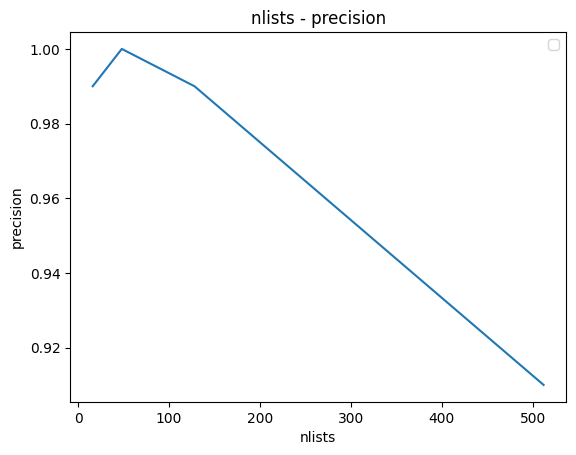

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


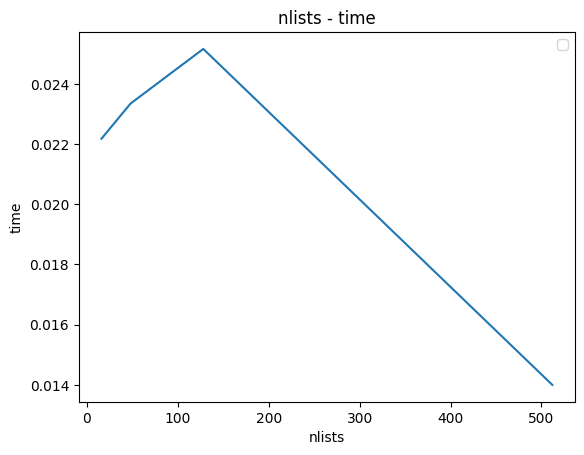

In [47]:
import math
times = []
precisions = []
for nlists in nlists_s:
    index = initIVFPQIndex(nlists=nlists)
    execution_times = timeit.repeat(lambda: index.search(np.array([query_point]), k), repeat=3, number=1)
    times.append(sum(execution_times) / len(execution_times))
    D, I =  index.search(np.array([query_point]), k)
    precisions.append(compareResultWithBruteForceRaw(I, actualNeighboursIndices[math.ceil(math.log(k, 10)) - 2], k))
plt.plot(nlists_s, precisions)

plt.xlabel('nlists')
plt.ylabel('precision')
plt.title('nlists - precision')

# Add a legend
plt.legend()

# Display the plot
plt.show()

plt.plot(nlists_s, times)

plt.xlabel('nlists')
plt.ylabel('time')
plt.title('nlists - time')

# Add a legend
plt.legend()

# Display the plot
plt.show()